In [1]:
!pip install timm

In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [3]:
print(os.listdir('Train_Test_Valid'))
print(os.listdir('Train_Test_Valid/Train'))  # Train 폴더의 목록
print(os.listdir('Train_Test_Valid/test'))   # test 폴더의 목록

['valid', 'test', 'Train']
['mauve_stinger_jellyfish', 'barrel_jellyfish', 'moon_jellyfish', 'lions_mane_jellyfish', 'blue_jellyfish', 'compass_jellyfish']
['mauve_stinger_jellyfish', 'barrel_jellyfish', 'lions_mane_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'Moon_jellyfish']


In [4]:
# [코드 2] 장치 설정 (GPU 사용 가능 시 GPU를 사용하도록 설정)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


In [5]:
# [코드 3] 데이터셋 경로 설정 및 전처리 정의
# 해파리 데이터셋 경로 (사용자가 지정한 경로로 수정하세요)
train_data_dir = 'Train_Test_Valid/Train'
valid_data_dir = 'Train_Test_Valid/valid'
test_data_dir = 'Train_Test_Valid/test'

# 이미지 전처리 파이프라인 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),          # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

In [6]:
# 데이터셋 및 데이터로더 생성
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['barrel_jellyfish', 'blue_jellyfish', 'compass_jellyfish', 'lions_mane_jellyfish', 'mauve_stinger_jellyfish', 'moon_jellyfish']
Number of classes: 6


In [7]:
# timm 모델 생성 및 설정 (resnet18 사용)
model = timm.create_model('resnet18', pretrained=False, num_classes=num_classes)
model = model.to(device)
# True로 하면 사전 학습된 가중치를 로드할 수 있지만, 현재 LMS에서는 불러오기가 안됨

In [8]:
# [코드 6] 손실 함수와 최적화 함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
# 모델 훈련 함수 정의 (검증 데이터셋 포함)
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10, device='cpu'):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        # 1) 훈련 단계
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct / total

        # 2) 검증 단계
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                val_loss = loss_fn(val_outputs, val_labels)
                val_running_loss += val_loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = val_correct / val_total

        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.4f}')

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


In [10]:
# 모델 평가 함수 정의 (테스트 데이터셋)
def evaluate_model(model, dataloader, loss_fn, device='cpu'):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [11]:
# 모델 훈련
epochs = 40
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs, device)


Epoch 1/40, Train Loss: 1.5866, Train Accuracy: 0.3422, Validation Loss: 2.3505, Validation Accuracy: 0.1026
Epoch 2/40, Train Loss: 1.3760, Train Accuracy: 0.4489, Validation Loss: 2.3574, Validation Accuracy: 0.1538
Epoch 3/40, Train Loss: 1.2838, Train Accuracy: 0.5044, Validation Loss: 2.4093, Validation Accuracy: 0.1538
Epoch 4/40, Train Loss: 1.2107, Train Accuracy: 0.5211, Validation Loss: 2.7026, Validation Accuracy: 0.2051
Epoch 5/40, Train Loss: 1.1748, Train Accuracy: 0.5333, Validation Loss: 2.8835, Validation Accuracy: 0.0256
Epoch 6/40, Train Loss: 1.1324, Train Accuracy: 0.5656, Validation Loss: 2.8647, Validation Accuracy: 0.0769
Epoch 7/40, Train Loss: 1.0093, Train Accuracy: 0.6289, Validation Loss: 3.0355, Validation Accuracy: 0.0513
Epoch 8/40, Train Loss: 0.9863, Train Accuracy: 0.6167, Validation Loss: 3.2336, Validation Accuracy: 0.1538
Epoch 9/40, Train Loss: 0.9677, Train Accuracy: 0.6367, Validation Loss: 2.7573, Validation Accuracy: 0.2308
Epoch 10/40, Train 

In [12]:
# 모델 검증(테스트 데이터셋)
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
# 아주 심각한 과적합이 발생함


Test Loss: 7.6849, Test Accuracy: 0.0000


In [13]:
# 훈련 이력 시각화 함수 (훈련 데이터와 검증 데이터 비교)
def plot_training_history(train_loss, train_acc, val_loss, val_acc):
    epochs_range = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, 'bo-', label='Training loss')
    plt.plot(epochs_range, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, 'bo-', label='Training accuracy')
    plt.plot(epochs_range, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

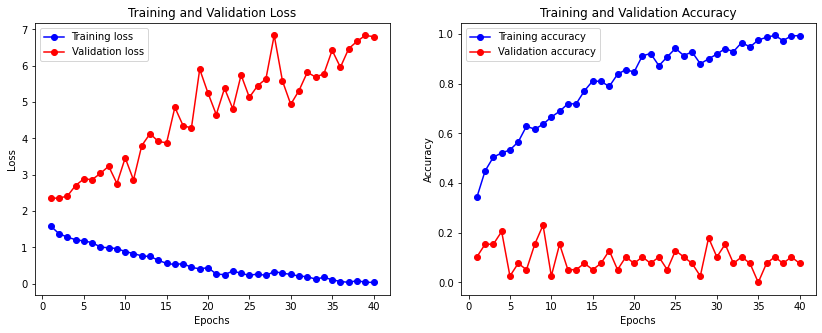

In [14]:
# 훈련 및 검증 이력 시각화
plot_training_history(train_loss_history, train_acc_history, val_loss_history, val_acc_history)